### Lab: Q-Learning to Solve the Cliff Walk Problem

### University of Virginia
### Reinforcement Learning
#### Last updated: May 26, 2025

---

#### Instructions:

In Sutton & Barto (Section 6.5), the Cliff Walking problem is presented. You will apply Q-learning to teach an agent to solve it.  

Consider the grid below, where an agent begins in starting state S and wishes to reach goal state G by walking on a path and keeping off The Cliff (the gray region).  At each time step, the agent can potentially take one step left, right, up, or down. There is no discounting.  It is not possible for the agent to move off the grid. If the agent visits The Cliff, it incurs reward -100 and is immediately sent back to the start. The reward is -1 on all transitions apart from The Cliff. This incentivizes the agent to reach G as quickly as possible.

**Note**: Do not use libraries from `networkx`, `gym`, `gymnasium` when solving this problem.

---

<img src="https://github.com/jackburke12/applied_reinforcement_learning/blob/main/04_q_learning/cliff_walk.png?raw=1">  

#### TOTAL POINTS: 12

---

#### 1) Clearly explain how you will set up the state space and action space.
**(POINTS: 2)**

Because the problem uses a grid, each state can be easily defined as a tuple with grid coordinates (row, column), where the row and column numbers are positive integers. The start state will have position (3,0) and the terminal state will have position (3, 11). The boundary states, which represent the cliff, will range from (3,1) to (3,10). Overall, there are 48 possible states.

The action space consists of the four directions the agent can move, represented by tuples that can be added to the state to get the resulting state. Thus the "up" action is represented by (-1,0), so the row moves up by one and the column stays the same. Taken from the starting position, this action would result in state (2,0). The down action is (1,0), left is (0, -1), and right is (0,1).

 When the agent is at a boundary state, it cannot take an action that would take it off of the grid, but the action is still available - it will just have no effect.


#### 2) Write a Q-learning algorithm that helps the agent learn a policy to reach the goal  
**(POINTS: 8)**.

Use $\epsilon$-greedy action selection with $\epsilon=0.1$.  
You can decide the other parameters as you wish.  

In [38]:
import numpy as np
import random

n_rows = 4
n_cols = 12

start = (3,0)
terminal = (3,11)
cliff = [(3,i) for i in range(1,11)]

actions = [(-1,0), (0,1), (1,0), (0,-1)]
n_actions = len(actions)

#Gets the index of the state in the lookup table
def get_state(row, col):
  return row * n_cols + col

def epsilon_greedy(Q, state, epsilon=0.1):
    if random.random() < epsilon:
        return random.randint(0, n_actions - 1)
    else:
        return np.argmax(Q[state])

def step(state, action):
    row, col = divmod(state, n_cols)
    dr, dc = actions[action]
    new_row, new_col = row + dr, col + dc

    new_row = min(max(new_row, 0), n_rows - 1)
    new_col = min(max(new_col, 0), n_cols - 1)
    next_state = get_state(new_row, new_col)

    # Default: normal move
    reward = -1
    completed = False
    final_pos = (new_row, new_col)

    # Cliff check
    if (new_row, new_col) in cliff:
        reward = -100
        next_state = get_state(*start)  # teleport back for Q-learning
        completed = True                # end episode for plotting clarity

    # Goal check
    elif (new_row, new_col) == terminal:
        reward = -1
        completed = True

    return next_state, reward, completed, final_pos

alpha = 0.5
gamma = 1.0
epsilon = 0.1
episodes = 500

Q = np.zeros((n_rows * n_cols, n_actions))

final_states = []

for episode in range(episodes):
  state = get_state(*start)
  completed = False
  total_reward = 0

  while not completed:
    action = epsilon_greedy(Q, state, epsilon)
    next_state, reward, completed, final_pos = step(state, action)

    Q[state, action] += alpha * (reward + gamma * np.max(Q[next_state]) - Q[state, action])

    state = next_state
    total_reward += reward

  final_states.append(final_pos[1])

  if (episode + 1) % 100 == 0:
    print(f"Episode {episode + 1}, Total Reward: {total_reward}")

# Derive greedy policy
policy = np.array([np.argmax(Q[s]) for s in range(n_rows * n_cols)]).reshape(n_rows, n_cols)

print("\nLearned greedy policy (0=UP, 1=RIGHT, 2=DOWN, 3=LEFT):")
print(policy)


Episode 100, Total Reward: -13
Episode 200, Total Reward: -13
Episode 300, Total Reward: -19
Episode 400, Total Reward: -15
Episode 500, Total Reward: -13

Learned greedy policy (0=UP, 1=RIGHT, 2=DOWN, 3=LEFT):
[[0 1 0 1 1 0 1 1 0 1 1 2]
 [0 1 1 1 1 2 1 1 1 1 1 2]
 [1 1 1 1 1 1 1 1 1 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0]]


**Note to grader for partial credit:**  
Student answers in parts 3-5 should help understand if the algorithm is implemented correctly.  


#### 3) After training the policy, print the row from the Q-table representing the starting state  

In [36]:
# ---- After training loop ----
start_state = get_state(*start)

# Raw Q-row for the starting state (length = 4 actions)
print("Q[start]:", Q[start_state])

action_names = ["UP", "RIGHT", "DOWN", "LEFT"]
for a, q in enumerate(Q[start_state]):
    print(f"{action_names[a]:>5}: {q: .3f}")


Q[start]: [ -13.         -112.99801864  -13.99953108  -13.99928398]
   UP: -13.000
RIGHT: -112.998
 DOWN: -14.000
 LEFT: -13.999


This makes sense - the reward for going right from the starting state, which would take the agent over the cliff, is very negative. The highest reward is up, which is the desired direction.

#### 4) Based on training results, create a plot that shows final state of each episode on the y-axis, and the episode number on the x-axis

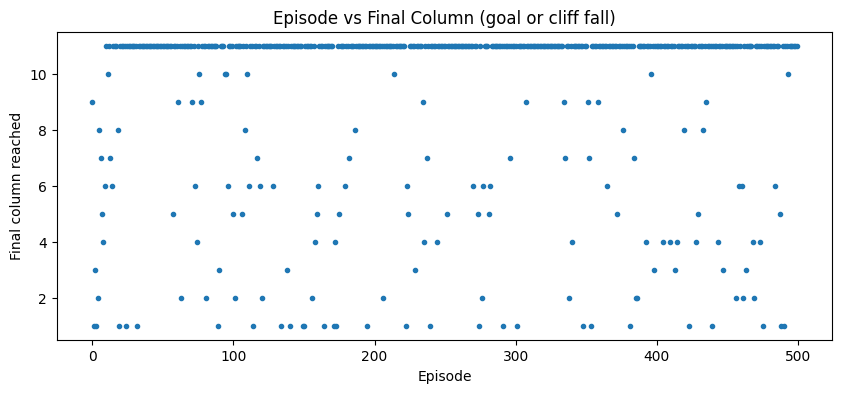

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(range(episodes), final_states, marker='.', linestyle='none')
plt.xlabel("Episode")
plt.ylabel("Final column reached")
plt.title("Episode vs Final Column (goal or cliff fall)")
plt.show()

#### 5) Given the learned policy, run one episode

Show evidence that the agent has learned how to successfully complete the Cliff walk

#### 6) Explain your results. Do they make sense?
**(POINTS: 2)**

**Note to grader for partial credit:** Grade based on the reasoning.